# Exploratory data analysis


Goal: understand how is the users behaviours in different datasets. We'll look at:

1. Movielens 100k
2. LastFM (definir tamanho) - Não consegui puxar esse dataset
3. Food.com
4. Yelp


Statistics we're looking for:

1. Basic stats: number of users, items, genres, sparsity
2. How active are users in the dataset. Plot number of iteractions (y) per user id (x), ranked by number of iteractions. Descriptive statistics
3. Given the results above, how many users are active, how many are inactive

## Imports and setups

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import spacy
import unicodedata
import re

In [2]:
MOVIELENS_PATH = "data/movielens-1m"
FOOD_COM_PATH = "data/food"
YELP_PATH = "data/yelp"

In [37]:
REVIEWS_PER_USER_THRESHOLD = 30

In [4]:
synonyms = {
    'children': 'child',
    'childs': 'child',
    'childrens': 'child',
    'thrill': 'thriller'
}

def normalize_word(word):
    return synonyms.get(word, word)

In [55]:


def text_preprocess(text):
    text = text.lower()
    text = text.strip()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'\s+', '-', text)
    return text


In [6]:
def preprocess_genres(df, genre_col="genres", SEP="|"):
    return df[genre_col].apply(
        lambda text: [
            normalize_word(
                re.sub(r'[^a-zA-Z0-9\s]', '', token)
            ) for token in text.split(SEP)]
    )

In [7]:
import itertools

def get_unique_values(series):
    return list(set(itertools.chain.from_iterable(series)))

## Movielens

### Loading data and cleaning

In [95]:
pd.read_csv(f"{MOVIELENS_PATH}/ratings.dat", sep="::")

/tmp/ipykernel_15228/3731094637.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(f"{MOVIELENS_PATH}/ratings.dat", sep="::")


,1,1193,5,978300760
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268
...,...,...,...,...
1000203,6040,1091,1,956716541
1000204,6040,1094,5,956704887
1000205,6040,562,5,956704746
1000206,6040,1096,4,956715648


In [96]:
ratings = pd.read_csv(f"{MOVIELENS_PATH}/ratings.dat", sep="::",  engine="python", encoding='ISO-8859-1', header=None,  names=['userId', 'movieId', 'Rating', 'timestamp'])

In [97]:
movies = pd.read_csv(f"{MOVIELENS_PATH}/movies.dat", sep="::",  engine="python", encoding='ISO-8859-1', header=None, names=['movieId', 'title', 'genre'])

In [98]:
movies["genre"] = movies["genre"].apply(lambda row: text_preprocess(row))

In [99]:
movies

,movieId,title,genre
0,1,Toy Story (1995),animation|children's|comedy
1,2,Jumanji (1995),adventure|children's|fantasy
2,3,Grumpier Old Men (1995),comedy|romance
3,4,Waiting to Exhale (1995),comedy|drama
4,5,Father of the Bride Part II (1995),comedy
...,...,...,...
3878,3948,Meet the Parents (2000),comedy
3879,3949,Requiem for a Dream (2000),drama
3880,3950,Tigerland (2000),drama
3881,3951,Two Family House (2000),drama


In [100]:
df = ratings.merge(movies, on="movieId")

In [101]:
time_df = df[["userId", "timestamp"]]
most_recent_df = time_df.groupby("userId")["timestamp"].max().reset_index()
most_recent_df.columns = ['userId', 'most_recent_timestamp']

In [102]:
most_recent_df

,userId,most_recent_timestamp
0,1,978824351
1,2,978300174
2,3,978298504
3,4,978294282
4,5,978246585
...,...,...
6035,6036,956755196
6036,6037,956801840
6037,6038,956717204
6038,6039,956758029


In [103]:
df = df.merge(most_recent_df, on="userId")

In [104]:
df

,userId,movieId,Rating,timestamp,title,genre,most_recent_timestamp
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),drama,978824351
1,1,661,3,978302109,James and the Giant Peach (1996),animation|children's|musical,978824351
2,1,914,3,978301968,My Fair Lady (1964),musical|romance,978824351
3,1,3408,4,978300275,Erin Brockovich (2000),drama,978824351
4,1,2355,5,978824291,"Bug's Life, A (1998)",animation|children's|comedy,978824351
...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,Weekend at Bernie's (1989),comedy,998315055
1000205,6040,1094,5,956704887,"Crying Game, The (1992)",drama|romance|war,998315055
1000206,6040,562,5,956704746,Welcome to the Dollhouse (1995),comedy|drama,998315055
1000207,6040,1096,4,956715648,Sophie's Choice (1982),drama,998315055


In [105]:
df['rating_age'] = df['most_recent_timestamp'] - df['timestamp']
df['rating_age_minutes'] = df['rating_age'] / 60
df['rating_age_hours'] = df['rating_age'] / 3600
df['rating_age_days'] = df['rating_age_hours'] / 24
df['rating_age_weeks'] = df['rating_age_days'] / 7
df = df.drop(columns=['rating_age', 'most_recent_timestamp', 'timestamp'])

In [106]:
df

,userId,movieId,Rating,title,genre,rating_age_minutes,rating_age_hours,rating_age_days,rating_age_weeks
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),drama,8726.516667,145.441944,6.060081,0.865726
1,1,661,3,James and the Giant Peach (1996),animation|children's|musical,8704.033333,145.067222,6.044468,0.863495
2,1,914,3,My Fair Lady (1964),musical|romance,8706.383333,145.106389,6.046100,0.863729
3,1,3408,4,Erin Brockovich (2000),drama,8734.600000,145.576667,6.065694,0.866528
4,1,2355,5,"Bug's Life, A (1998)",animation|children's|comedy,1.000000,0.016667,0.000694,0.000099
...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,Weekend at Bernie's (1989),comedy,693308.566667,11555.142778,481.464282,68.780612
1000205,6040,1094,5,"Crying Game, The (1992)",drama|romance|war,693502.800000,11558.380000,481.599167,68.799881
1000206,6040,562,5,Welcome to the Dollhouse (1995),comedy|drama,693505.150000,11558.419167,481.600799,68.800114
1000207,6040,1096,4,Sophie's Choice (1982),drama,693323.450000,11555.390833,481.474618,68.782088


In [107]:
df.to_csv(f"{MOVIELENS_PATH}/movielens_1m.csv", sep=",", index=False)

In [108]:
df = pd.read_csv(f"{MOVIELENS_PATH}/movielens_1m.csv")

### Dataset statistics

* Number of users
* Number of items
* Sparsity
* Unique genres

In [109]:
df

,userId,movieId,Rating,title,genre,rating_age_minutes,rating_age_hours,rating_age_days,rating_age_weeks
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),drama,8726.516667,145.441944,6.060081,0.865726
1,1,661,3,James and the Giant Peach (1996),animation|children's|musical,8704.033333,145.067222,6.044468,0.863495
2,1,914,3,My Fair Lady (1964),musical|romance,8706.383333,145.106389,6.046100,0.863729
3,1,3408,4,Erin Brockovich (2000),drama,8734.600000,145.576667,6.065694,0.866528
4,1,2355,5,"Bug's Life, A (1998)",animation|children's|comedy,1.000000,0.016667,0.000694,0.000099
...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,Weekend at Bernie's (1989),comedy,693308.566667,11555.142778,481.464282,68.780612
1000205,6040,1094,5,"Crying Game, The (1992)",drama|romance|war,693502.800000,11558.380000,481.599167,68.799881
1000206,6040,562,5,Welcome to the Dollhouse (1995),comedy|drama,693505.150000,11558.419167,481.600799,68.800114
1000207,6040,1096,4,Sophie's Choice (1982),drama,693323.450000,11555.390833,481.474618,68.782088


In [110]:
df['genres'] = preprocess_genres(df, "genre")
df = df.drop(columns=["genre"])

In [111]:
df

,userId,movieId,Rating,title,rating_age_minutes,rating_age_hours,rating_age_days,rating_age_weeks,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),8726.516667,145.441944,6.060081,0.865726,[drama]
1,1,661,3,James and the Giant Peach (1996),8704.033333,145.067222,6.044468,0.863495,"[animation, child, musical]"
2,1,914,3,My Fair Lady (1964),8706.383333,145.106389,6.046100,0.863729,"[musical, romance]"
3,1,3408,4,Erin Brockovich (2000),8734.600000,145.576667,6.065694,0.866528,[drama]
4,1,2355,5,"Bug's Life, A (1998)",1.000000,0.016667,0.000694,0.000099,"[animation, child, comedy]"
...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,Weekend at Bernie's (1989),693308.566667,11555.142778,481.464282,68.780612,[comedy]
1000205,6040,1094,5,"Crying Game, The (1992)",693502.800000,11558.380000,481.599167,68.799881,"[drama, romance, war]"
1000206,6040,562,5,Welcome to the Dollhouse (1995),693505.150000,11558.419167,481.600799,68.800114,"[comedy, drama]"
1000207,6040,1096,4,Sophie's Choice (1982),693323.450000,11555.390833,481.474618,68.782088,[drama]


In [112]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
n_interactions = df.shape[0]

sparsity =100 - 100* (n_interactions / (n_users * n_movies) )

In [113]:
df['genres']

0                                 [drama]
1             [animation, child, musical]
2                      [musical, romance]
3                                 [drama]
4              [animation, child, comedy]
                        ...              
1000204                          [comedy]
1000205             [drama, romance, war]
1000206                   [comedy, drama]
1000207                           [drama]
1000208    [child, drama, fantasy, scifi]
Name: genres, Length: 1000209, dtype: object

In [116]:
len(get_unique_values(df['genres']))

18

In [27]:
sparsity

95.53163743776872

In [28]:
n_users

6040

In [29]:
n_movies

3706

### Activity statistics


1. Plot the activity curve.
2. Get the number of active users. To this, we'll select the top 20% most active users.

In [118]:
df_by_user = df.groupby("userId").agg({'Rating': list, 'rating_age_hours': list}).reset_index()

In [119]:
df_by_user['num_ratings'] = df_by_user['Rating'].apply(lambda r: len(r))

In [120]:
df_by_user

,userId,Rating,rating_age_hours,num_ratings
0,1,"[5, 3, 3, 4, 5, 3, 5, 5, 4, 4, 5, 4, 4, 4, 5, ...","[145.44194444444443, 145.06722222222223, 145.1...",53
1,2,"[5, 4, 4, 3, 4, 4, 5, 3, 3, 3, 5, 4, 3, 3, 2, ...","[0.4069444444444444, 0.3261111111111111, 0.153...",129
2,3,"[4, 2, 3, 4, 3, 4, 4, 4, 3, 3, 5, 3, 5, 4, 5, ...","[0.0991666666666666, 0.0205555555555555, 0.176...",51
3,4,"[5, 3, 4, 4, 4, 5, 5, 4, 2, 5, 5, 4, 4, 4, 4, ...","[0.0761111111111111, 0.0994444444444444, 0.0, ...",21
4,5,"[4, 4, 5, 3, 2, 5, 4, 4, 2, 3, 2, 3, 4, 3, 1, ...","[0.9486111111111112, 1.105, 0.5072222222222222...",198
...,...,...,...,...
6035,6036,"[3, 3, 2, 3, 2, 2, 5, 2, 2, 3, 4, 5, 3, 3, 5, ...","[0.7525, 0.4413888888888889, 0.043888888888888...",888
6036,6037,"[3, 4, 3, 4, 3, 5, 3, 5, 5, 3, 4, 4, 3, 5, 4, ...","[23.078611111111112, 25.71527777777778, 23.033...",202
6037,6038,"[4, 3, 5, 4, 4, 5, 5, 4, 4, 4, 4, 5, 3, 5, 3, ...","[0.6636111111111112, 2.8825, 2.656666666666666...",20
6038,6039,"[4, 4, 4, 4, 3, 4, 3, 3, 4, 5, 3, 4, 5, 5, 4, ...","[14.466388888888888, 14.680833333333334, 14.43...",123


In [121]:
df_by_user['num_ratings'].describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: num_ratings, dtype: float64

In [128]:
df_by_user['num_ratings'].quantile(0.8).item()

253.0

In [130]:
df_by_user['num_ratings'].quantile(0.2).item()

38.0

In [133]:
active_users = df_by_user[df_by_user["num_ratings"] >= 253]["userId"].unique()

In [139]:
active_users_df = df[df["userId"].isin(active_users)]

In [136]:
len(active_users)

1215

In [134]:
not_active_users = df_by_user[(df_by_user["num_ratings"] >= 38.0) & (df_by_user["num_ratings"] < 253.0)]["userId"].unique()

In [140]:
not_active_users_df = df[df["userId"].isin(not_active_users)]

In [141]:
not_active_users_df

,userId,movieId,Rating,title,rating_age_minutes,rating_age_hours,rating_age_days,rating_age_weeks,genres
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975),8726.516667,145.441944,6.060081,0.865726,[drama]
1,1,661,3,James and the Giant Peach (1996),8704.033333,145.067222,6.044468,0.863495,"[animation, child, musical]"
2,1,914,3,My Fair Lady (1964),8706.383333,145.106389,6.046100,0.863729,"[musical, romance]"
3,1,3408,4,Erin Brockovich (2000),8734.600000,145.576667,6.065694,0.866528,[drama]
4,1,2355,5,"Bug's Life, A (1998)",1.000000,0.016667,0.000694,0.000099,"[animation, child, comedy]"
...,...,...,...,...,...,...,...,...,...
999863,6039,1081,4,Victor/Victoria (1982),867.333333,14.455556,0.602315,0.086045,"[comedy, musical]"
999864,6039,1083,3,"Great Race, The (1965)",866.300000,14.438333,0.601597,0.085942,"[comedy, musical]"
999865,6039,1086,4,Dial M for Murder (1954),864.116667,14.401944,0.600081,0.085726,"[mystery, thriller]"
999866,6039,1088,4,Dirty Dancing (1987),866.833333,14.447222,0.601968,0.085995,"[musical, romance]"


In [137]:
len(not_active_users)

3620

Text(0.5, 1.0, 'Distribution of the number of ratings provided by users')

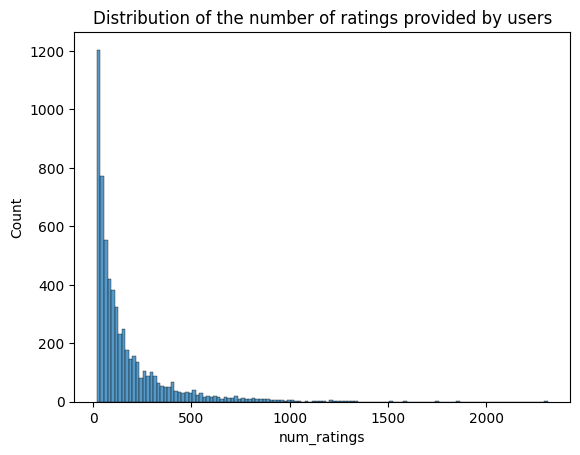

In [124]:
sns.histplot(df_by_user['num_ratings'])
plt.title("Distribution of the number of ratings provided by users")

## Yelp dataset

In [8]:
YELP_PATH

'data/yelp'

In [9]:
business_df = pd.read_csv(f"{YELP_PATH}/yelp_academic_dataset_business.csv")[["business_id","name", "categories"]]

/tmp/ipykernel_9290/281212971.py:1: DtypeWarning: Columns (9,15,28,37,40,53,59,82,84,102) have mixed types. Specify dtype option on import or set low_memory=False.
  business_df = pd.read_csv(f"{YELP_PATH}/yelp_academic_dataset_business.csv")[["business_id","name", "categories"]]


In [10]:
business_df

,business_id,name,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,"Brewpubs, Breweries, Food"
...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,"Nail Salons, Beauty & Spas"
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,"Pets, Nurseries & Gardening, Pet Stores, Hobby..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"Shopping, Jewelry, Piercing, Toy Stores, Beaut..."
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,"Fitness/Exercise Equipment, Eyewear & Optician..."


In [11]:
business_df.isna().sum()

business_id      0
name             0
categories     103
dtype: int64

In [12]:
reviews_df = pd.read_csv(f"{YELP_PATH}/yelp_academic_dataset_review.csv")[["review_id","user_id", "business_id", "stars", "date"]]

In [13]:
reviews_df

,review_id,user_id,business_id,stars,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15
...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,2022-01-19 18:59:27


In [14]:
reviews_df.isna().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
dtype: int64

In [15]:
user_df =  pd.read_csv(f"{YELP_PATH}/yelp_academic_dataset_user.csv")[["user_id", "review_count", "yelping_since"]]

/tmp/ipykernel_9290/1957518789.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  user_df =  pd.read_csv(f"{YELP_PATH}/yelp_academic_dataset_user.csv")[["user_id", "review_count", "yelping_since"]]


In [16]:
user_df

,user_id,review_count,yelping_since
0,qVc8ODYU5SZjKXVBgXdI7w,585,2007-01-25 16:47:26
1,j14WgRoU_-2ZE1aw1dXrJg,4333,2009-01-25 04:35:42
2,2WnXYQFK0hXEoTxPtV2zvg,665,2008-07-25 10:41:00
3,SZDeASXq7o05mMNLshsdIA,224,2005-11-29 04:38:33
4,hA5lMy-EnncsH4JoR-hFGQ,79,2007-01-05 19:40:59
...,...,...,...
1987892,fB3jbHi3m0L2KgGOxBv6uw,23,2015-01-06 00:31:31
1987893,68czcr4BxJyMQ9cJBm6C7Q,1,2016-06-14 07:20:52
1987894,1x3KMskYxOuJCjRz70xOqQ,4,2017-02-04 15:31:58
1987895,ulfGl4tdbrH05xKzh5lnog,2,2011-01-14 00:29:08


In [17]:
user_df.isna().sum()

user_id          0
review_count     0
yelping_since    0
dtype: int64

### Preprocesing

We'll follow the same preprocessing framework here:

* Remove items without genre information
* Ratings higher than 4 are considered 1. otherwise, 0
* Items without interactions are removed
* Interactions without timestamp are removed
* only retained users with at least 30 positive interactions,


In [18]:
business_cleaned_df = business_df[~business_df["categories"].isna()]

In [32]:
business_cleaned_df['categories'] = business_cleaned_df['categories'].apply(lambda cat: cat.split(","))

/tmp/ipykernel_9290/3925402473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_cleaned_df['categories'] = business_cleaned_df['categories'].apply(lambda cat: cat.split(","))


In [19]:
reviews_df["binarized_rating"] = reviews_df["stars"].apply(lambda rating: int(rating >= 4))

In [20]:
reviews_df.groupby(["user_id", "business_id"]).size().describe()

count    6.745760e+06
mean     1.036248e+00
std      2.245669e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.000000e+01
dtype: float64

We see that we can have duplicates of user reviews for business. For now, we'll simply drop the duplicates. ALternatively, we could just consider the most recent one.

In [42]:
active_users = user_df[user_df["review_count"] > REVIEWS_PER_USER_THRESHOLD].user_id

In [21]:
reviews_df = reviews_df.drop_duplicates(subset=["user_id", "business_id"])

In [43]:
reviews_from_active_users = reviews_df[reviews_df["user_id"].isin(active_users)]

Finally, we'll enrich the reviews with business information (categories). We'll perform an inner join to assure that business without reviews are not considered

In [44]:
yelp_df = reviews_from_active_users.merge(business_cleaned_df, on="business_id")

In [45]:
yelp_df

,review_id,user_id,business_id,stars,date,binarized_rating,name,categories
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,2018-07-07 22:09:11,0,Turning Point of North Wales,"[Restaurants, Breakfast & Brunch, Food, Jui..."
1,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,2014-02-05 20:30:30,0,Kettle Restaurant,"[Restaurants, Breakfast & Brunch]"
2,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,2017-01-14 20:54:15,1,Melt,"[Sandwiches, Beer, Wine & Spirits, Bars, F..."
3,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,2015-01-03 23:21:18,1,The Voodoo Bone Lady Tours,"[Supernatural Readings, Tours, Hotels & Trav..."
4,rGQRf8UafX7OTlMNN19I8A,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5.0,2015-06-21 14:48:06,1,Shalimar Fine Jewelers,"[Shopping, Jewelry]"
...,...,...,...,...,...,...,...,...
3009668,YVX1Wsa4LYxjvFwuHBb_gA,RKPkxOYQlM0BjhM-H6_vAw,X4mouE_cMiwbfyCPZ_K-FA,4.0,2015-01-23 23:52:03,1,Marhaba,"[Halal, Lebanese, Mediterranean, Greek, Re..."
3009669,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2021-03-31 16:55:10,1,Canoe Outpost-Little Manatee River,"[Hotels & Travel, Active Life, Boating, Raf..."
3009670,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,2019-12-30 03:56:30,1,The Home Depot,"[Building Supplies, Home Services, Hardware ..."
3009671,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,2022-01-19 18:59:27,1,Sauce on the Side,"[Desserts, Pizza, Salad, Food, Beer, Wine..."


### Dataset statistics

* Number of users
* number of items
* Sparsity
* Numbver of unique categories

In [ ]:
text

In [57]:
yelp_df["categories"] = yelp_df["categories"].apply(lambda cat: [text_preprocess(w) for w in cat])

In [46]:
n_users = yelp_df['user_id'].nunique()
n_recipes = yelp_df['business_id'].nunique()
n_interactions = yelp_df.shape[0]

sparsity =100 - 100* (n_interactions / (n_users * n_recipes) )

In [47]:
n_users

298821

In [48]:
n_recipes

142061

In [49]:
sparsity

99.99291021067853

In [58]:
len(get_unique_values(yelp_df["categories"]))

1310

### Interactions metrics

In [51]:
yelp_df_per_user = yelp_df.groupby("user_id").size().reset_index().rename(columns={0: "num_ratings"})

In [52]:
yelp_df_per_user["num_ratings"].describe()

count    298821.000000
mean         10.071826
std          28.656671
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max        2199.000000
Name: num_ratings, dtype: float64

## Food.com dataset

Because this dataset doesn´t explicitly contain information about what is the genre of an item, we have some freedom here: we can use the tags, the minutes to prepare or number of steps (as in: short recipes, medium-sized recipes, longer recipes). For simplicity, we can just use tags.

In [113]:
recipes = pd.read_csv(f"{FOOD_COM_PATH}/RAW_recipes.csv").drop(columns=["contributor_id", "submitted", "nutrition", "steps", "description", "n_ingredients", "minutes", "ingredients", "n_steps"])

In [114]:
recipes['tags'] = recipes['tags'].apply(lambda tag: tag.strip('[]').split(','))


In [115]:
interactions = pd.read_csv(f"{FOOD_COM_PATH}/RAW_interactions.csv").drop(columns=["review"])

### Preprocessing


We'll be removing tags that don´t describe the item or are some sort of data processing mistake.

we'll follow, if applicable, the same data processing procedure done in da Silva et al 2025:

* Remove items without genre information
* Ratings higher than 3 are considered 1. otherwise, 0
* Items without interactions are removed
* Interactions without timestamp are removed
* [TODO] only retained users with at least 30 positive interactions,

As we will see, there isn't interactions with null timestamp or items without genres for this dataset.

We additionally remove recipes with an outlier ammount of genres, as described bellow

***

**Preprocessing the interactions df**

In [117]:
interactions.isna().sum()

user_id      0
recipe_id    0
date         0
rating       0
dtype: int64

In [ ]:
interactions["binarized_rating"] = interactions["rating"].apply(lambda r: int(r > 3))

In [130]:
interactions

,user_id,recipe_id,date,rating,binarized_rating
0,38094,40893,2003-02-17,4,1
1,1293707,40893,2011-12-21,5,1
2,8937,44394,2002-12-01,4,1
3,126440,85009,2010-02-27,5,1
4,57222,85009,2011-10-01,5,1
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,0
1132363,583662,386618,2009-09-29,5,1
1132364,157126,78003,2008-06-23,5,1
1132365,53932,78003,2009-01-11,4,1


***

***Handling the recipes data***

In [119]:
TAGS_TO_REMOVE = [' ', 'a1-sauce', 'main-ingredient', 'preparation', 'cuisine', 'dietary', 'occasion', 'less_thansql:name_topics_of_recipegreater_than', 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.']

In [120]:
def preprocess_tags(tag_list):
    return [tag for tag in tag_list if tag not in TAGS_TO_REMOVE]
    

In [121]:
recipes['tags'] = [
    [tag.strip().replace("'", "") for tag in preprocess_tags(tag_list)]
    for tag_list in recipes['tags']
]


In [122]:
sorted(get_unique_values(recipes['tags']))

['',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-crock-pot',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 '

In [123]:
len(get_unique_values(recipes['tags']))

552

In [124]:
recipes["n_tags"] = recipes["tags"].apply(lambda tags: len(tags))

Although it will not be necessary to remove recipes with 0 genres, we will remove outliers in terms of number of tags

In [125]:
recipes["n_tags"].describe()

count    231637.000000
mean         17.880080
std           7.244332
min           1.000000
25%          13.000000
50%          17.000000
75%          22.000000
max          73.000000
Name: n_tags, dtype: float64

In [126]:
Q3 = recipes["n_tags"].quantile(0.75).item()
Q1 = recipes["n_tags"].quantile(0.25).item()

IQR = Q3-Q1
upper_bound = Q3 + 1.5 * IQR


In [127]:
upper_bound

35.5

In [128]:
recipes[recipes["n_tags"] > upper_bound]

,name,id,tags,n_tags
20,cream of spinach soup,76808,"[60-minutes-or-less, time-to-make, course, mai...",40
65,munch without guilt tomatoes,30300,"[15-minutes-or-less, time-to-make, course, mai...",39
89,sour cream avocado dip vegan,112959,"[lactose, 15-minutes-or-less, time-to-make, co...",38
99,the woiks dilly burgers,34930,"[bacon, 60-minutes-or-less, time-to-make, cour...",43
100,tide me over indian chaat simple veggie salad,63793,"[15-minutes-or-less, time-to-make, course, mai...",38
...,...,...,...,...
231294,zucchini parmesan with lemon,15236,"[15-minutes-or-less, time-to-make, course, mai...",38
231298,zucchini pasta primavera raw vegan,433946,"[30-minutes-or-less, time-to-make, course, mai...",39
231397,zucchini stuffed with feta and basil,72857,"[30-minutes-or-less, time-to-make, course, mai...",41
231490,zucchini pineapple ginger jam kicked up with...,325574,"[60-minutes-or-less, time-to-make, course, mai...",36


In [129]:
recipes_filtered = recipes[recipes["n_tags"] <= upper_bound]

**Checking for id duplication** 

In [141]:
recipes_filtered.groupby("id").size().describe()

count    227641.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

In [142]:
interactions

,user_id,recipe_id,date,rating,binarized_rating
0,38094,40893,2003-02-17,4,1
1,1293707,40893,2011-12-21,5,1
2,8937,44394,2002-12-01,4,1
3,126440,85009,2010-02-27,5,1
4,57222,85009,2011-10-01,5,1
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,0
1132363,583662,386618,2009-09-29,5,1
1132364,157126,78003,2008-06-23,5,1
1132365,53932,78003,2009-01-11,4,1


In [143]:
interactions.groupby(["user_id", "recipe_id"]).size().describe()

count    1132367.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
dtype: float64

Dataset should not contain interaction duplications per recipe id.

In [148]:
food_df = recipes_filtered.merge(interactions, right_on="recipe_id", left_on="id")[["user_id", "recipe_id", "tags", "n_tags", "date", "rating", "binarized_rating"]]

In [149]:
food_df

,user_id,recipe_id,tags,n_tags,date,rating,binarized_rating
0,4470,137739,"[60-minutes-or-less, time-to-make, course, mai...",20,2006-02-18,5,1
1,593927,137739,"[60-minutes-or-less, time-to-make, course, mai...",20,2010-08-21,5,1
2,178427,137739,"[60-minutes-or-less, time-to-make, course, mai...",20,2011-12-05,5,1
3,28603,31490,"[30-minutes-or-less, time-to-make, course, mai...",20,2002-08-19,0,0
4,346277,31490,"[30-minutes-or-less, time-to-make, course, mai...",20,2006-08-27,5,1
...,...,...,...,...,...,...,...
1102209,844554,308080,"[60-minutes-or-less, time-to-make, course, mai...",13,2009-10-14,5,1
1102210,804234,298512,"[30-minutes-or-less, time-to-make, course, pre...",12,2008-05-02,1,0
1102211,866651,298509,"[30-minutes-or-less, time-to-make, course, pre...",15,2008-06-19,1,0
1102212,1546277,298509,"[30-minutes-or-less, time-to-make, course, pre...",15,2010-02-08,5,1


### Dataset statistics

In [154]:
n_users = food_df['user_id'].nunique()
n_recipes = food_df['recipe_id'].nunique()
n_interactions = food_df.shape[0]

sparsity =100 - 100* (n_interactions / (n_users * n_recipes) )

In [152]:
n_users

222204

In [155]:
n_recipes

227641

In [151]:
sparsity

99.99782096821296

In [156]:
n_genres = len(get_unique_values(food_df["tags"]))

In [157]:
n_genres

552

### Interaction statistics

In [163]:
food_df_per_user = food_df.groupby("user_id").size().reset_index().rename(columns={0: "num_ratings"})

In [166]:
food_df_per_user["num_ratings"].describe()

count    222204.000000
mean          4.960370
std          49.156963
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        7547.000000
Name: num_ratings, dtype: float64

In [ ]:
food_df_per_user['num_ratings'].quantile(0.8).item()

In [172]:
food_df_per_user['num_ratings'].quantile(0.95).item()

11.0

In [173]:
active_food_users = food_df_per_user[food_df_per_user['num_ratings'] >= 11]["user_id"]

In [174]:
food_df[food_df["user_id"].isin(active_food_users)]

,user_id,recipe_id,tags,n_tags,date,rating,binarized_rating
0,4470,137739,"[60-minutes-or-less, time-to-make, course, mai...",20,2006-02-18,5,1
1,593927,137739,"[60-minutes-or-less, time-to-make, course, mai...",20,2010-08-21,5,1
2,178427,137739,"[60-minutes-or-less, time-to-make, course, mai...",20,2011-12-05,5,1
3,28603,31490,"[30-minutes-or-less, time-to-make, course, mai...",20,2002-08-19,0,0
5,319943,31490,"[30-minutes-or-less, time-to-make, course, mai...",20,2009-07-18,4,1
...,...,...,...,...,...,...,...
1102205,428885,308080,"[60-minutes-or-less, time-to-make, course, mai...",13,2008-10-09,5,1
1102206,28177,308080,"[60-minutes-or-less, time-to-make, course, mai...",13,2009-10-05,5,1
1102207,128473,308080,"[60-minutes-or-less, time-to-make, course, mai...",13,2009-10-06,5,1
1102208,226863,308080,"[60-minutes-or-less, time-to-make, course, mai...",13,2009-10-11,5,1


In [175]:
only_active_users_food_df = food_df_per_user[food_df_per_user['num_ratings'] >= 11]

<Axes: xlabel='num_ratings', ylabel='Count'>

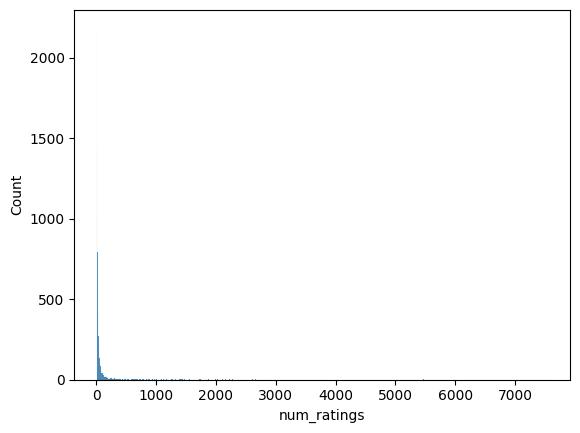

In [176]:
sns.histplot(only_active_users_food_df["num_ratings"])

**Due to the low number of ratings per users, this dataset is not useful to perform a simulated comparison for active vs unactive users**